# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [275]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

# 1. Load Dataset

In [276]:
df = pd.read_csv('./data/total.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('Date', inplace=True)

In [277]:
df.rename(columns={'TARGET':'oversea_inflow'}, inplace=True)

In [278]:
df['target'] = df['oversea_inflow'].diff()

In [279]:
cols = ['EURO_conf',
 'CHINA_conf',
 'ASIA_conf',
 'AMERICA_conf',]

In [280]:
cols

['EURO_conf', 'CHINA_conf', 'ASIA_conf', 'AMERICA_conf']

In [281]:
t_cols = []
for col in cols:
    tmp = '{}_1'.format(col)
    t_cols.append(tmp)
    df[tmp] = df['{}'.format(col)].diff()

In [282]:
df.isnull().sum()

EURO_conf         0
CHINA_conf        0
ASIA_conf         0
AMERICA_conf      0
EURO_roam         0
CHINA_roam        0
ASIA_roam         0
AMERICA_roam      0
oversea_inflow    0
NEWS              0
target            1
EURO_conf_1       1
CHINA_conf_1      1
ASIA_conf_1       1
AMERICA_conf_1    1
dtype: int64

In [283]:
t_cols

['EURO_conf_1', 'CHINA_conf_1', 'ASIA_conf_1', 'AMERICA_conf_1']

In [284]:
df.head()

,EURO_conf,CHINA_conf,ASIA_conf,AMERICA_conf,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,NEWS,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1
Date,,,,,,,,,,,,,,,
2020-01-22,0,548,5,1,1955.0,3014.0,8946.0,701.0,1,430,NaN,NaN,NaN,NaN,NaN
2020-01-23,0,643,9,1,1913.0,2677.0,7924.0,943.0,1,452,0.0,0.0,95.0,4.0,0.0
2020-01-24,2,920,15,2,2286.0,2197.0,7356.0,864.0,2,421,1.0,2.0,277.0,6.0,1.0
2020-01-25,3,1406,17,2,1472.0,1825.0,7518.0,828.0,2,506,0.0,1.0,486.0,2.0,0.0
2020-01-26,3,2075,22,5,1932.0,3252.0,11149.0,900.0,3,552,1.0,0.0,669.0,5.0,3.0


In [285]:
df.loc['2020-01-22',t_cols] = 0
df.target.iloc[0] = 0

In [286]:
# 일일 해외유입 확진자를 구할때 첫번째 로우는 NaN이기 때문에 0값을 넣어준다.
df['target'][0] = 0

In [287]:
df.drop(cols, axis=1, inplace=True)

In [288]:
df.tail()

,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,NEWS,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1
Date,,,,,,,,,,,
2020-04-24,39.0,197.0,311.0,99.0,1023,1708,2.0,1900.0,15.0,4431.0,36188.0
2020-04-25,34.0,73.0,298.0,108.0,1027,1107,4.0,13407.0,10.0,4266.0,32796.0
2020-04-26,62.0,126.0,294.0,100.0,1037,1176,10.0,10354.0,3.0,4027.0,27631.0
2020-04-27,50.0,67.0,194.0,106.0,1044,1353,7.0,12612.0,6.0,4311.0,22412.0
2020-04-28,15.0,143.0,224.0,102.0,1056,999,12.0,11645.0,22.0,3456.0,24385.0


## lag 변수 생성

In [289]:
lag_amount = 7

for i in range(lag_amount):
    df['lag{}'.format(i+1)] = df['target'].shift(i+1)
    
df.dropna(inplace=True)

In [290]:
df.head()

,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,NEWS,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Date,,,,,,,,,,,,,,,,,,
2020-01-29,1798.0,2416.0,9716.0,829.0,4,906,0.0,1.0,578.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2020-01-30,1539.0,2211.0,8264.0,860.0,6,749,2.0,0.0,2054.0,9.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2020-01-31,1858.0,2054.0,8540.0,739.0,7,726,1.0,5.0,1661.0,13.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0
2020-02-01,1966.0,1751.0,8167.0,1069.0,8,529,1.0,5.0,2089.0,12.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0
2020-02-02,2009.0,1721.0,8525.0,1099.0,10,732,2.0,2.0,4739.0,4.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0


In [291]:
df.tail()

,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,NEWS,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Date,,,,,,,,,,,,,,,,,,
2020-04-24,39.0,197.0,311.0,99.0,1023,1708,2.0,1900.0,15.0,4431.0,36188.0,4.0,6.0,5.0,8.0,5.0,10.0,16.0
2020-04-25,34.0,73.0,298.0,108.0,1027,1107,4.0,13407.0,10.0,4266.0,32796.0,2.0,4.0,6.0,5.0,8.0,5.0,10.0
2020-04-26,62.0,126.0,294.0,100.0,1037,1176,10.0,10354.0,3.0,4027.0,27631.0,4.0,2.0,4.0,6.0,5.0,8.0,5.0
2020-04-27,50.0,67.0,194.0,106.0,1044,1353,7.0,12612.0,6.0,4311.0,22412.0,10.0,4.0,2.0,4.0,6.0,5.0,8.0
2020-04-28,15.0,143.0,224.0,102.0,1056,999,12.0,11645.0,22.0,3456.0,24385.0,7.0,10.0,4.0,2.0,4.0,6.0,5.0


# Data Exploration

In [292]:
# 결측치 확인
df.isnull().sum()

EURO_roam         0
CHINA_roam        0
ASIA_roam         0
AMERICA_roam      0
oversea_inflow    0
NEWS              0
target            0
EURO_conf_1       0
CHINA_conf_1      0
ASIA_conf_1       0
AMERICA_conf_1    0
lag1              0
lag2              0
lag3              0
lag4              0
lag5              0
lag6              0
lag7              0
dtype: int64

In [293]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['target'].shape))

전체 데이터 shape: (91, 18)
target feature shape: (91,)


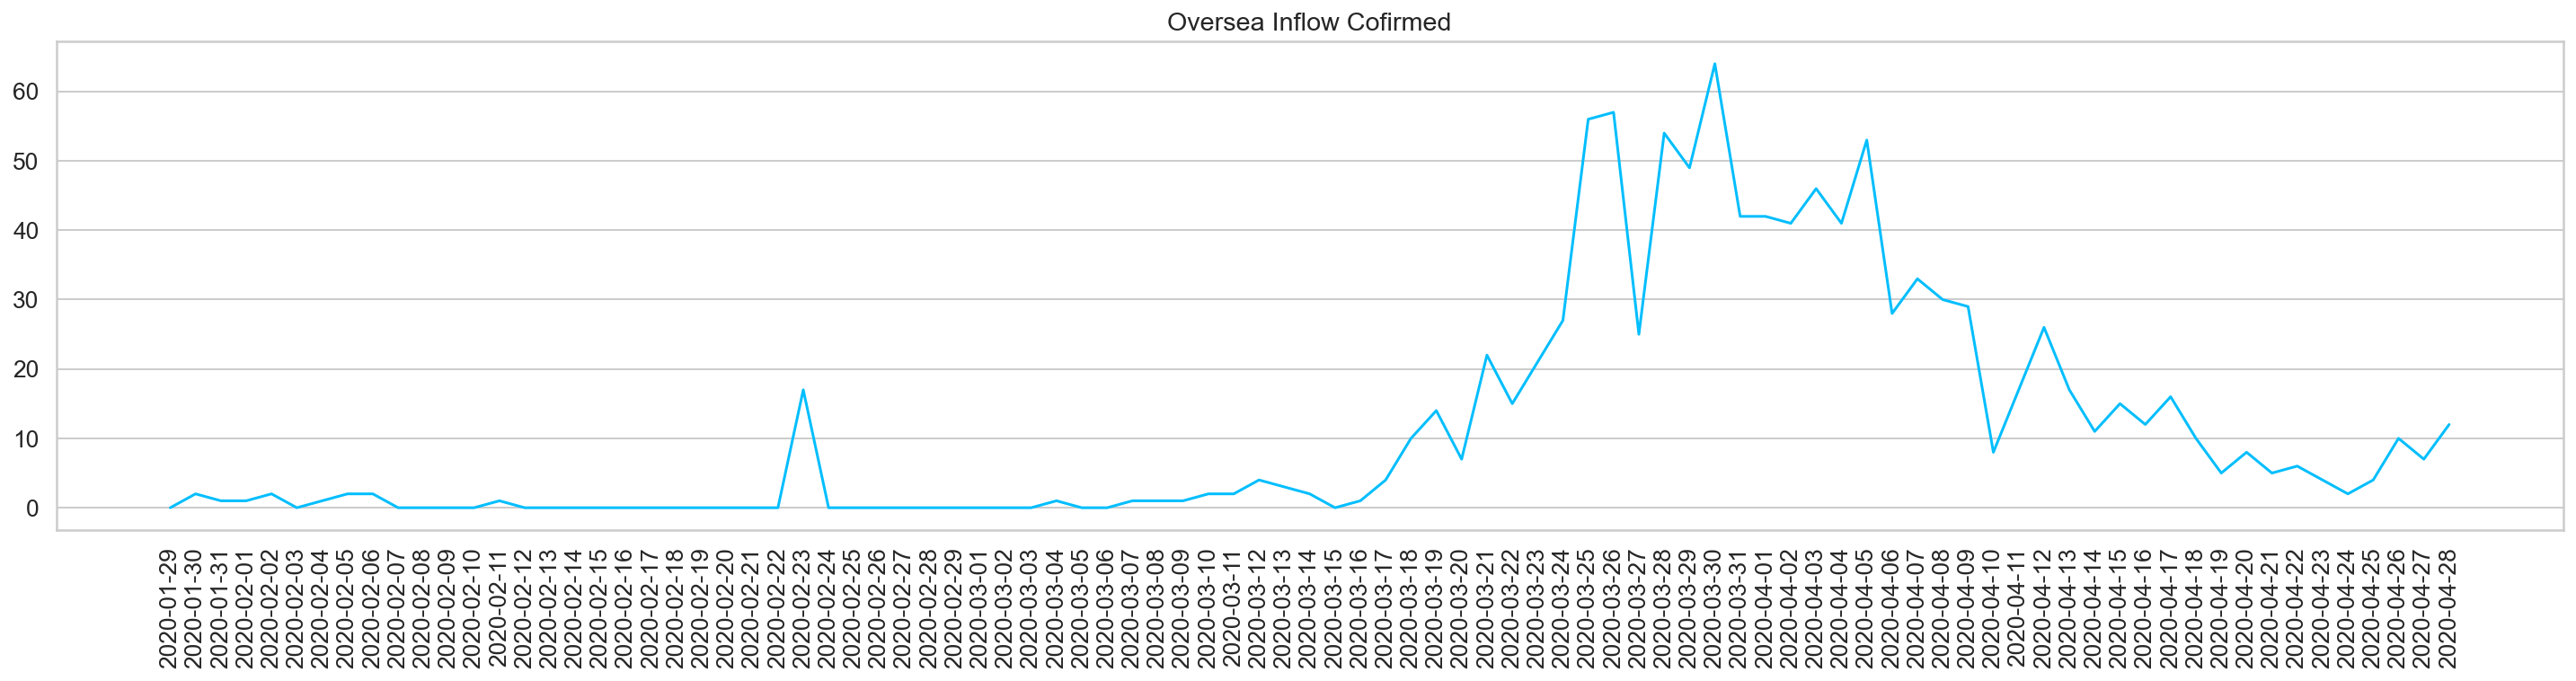

In [294]:
plt.figure(figsize=(25,5))
plt.plot(df['target'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

# Preprocessing

In [295]:
# 테스트 데이터 수
test_data_size = 21

# X변수들과 y변수 구분
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [296]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [297]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (70, 17)
test set :  (21, 17)


In [298]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    
    for i in range(len(array)-seq_length-1):
        tmp = array[i:(i+seq_length)]
        res.append(tmp)
        
    return res

In [299]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [300]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [301]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([68, 1, 17])
X_test : torch.Size([19, 1, 17])
y_train : torch.Size([68, 1])
y_test : torch.Size([19, 1])


# Building a Model

In [302]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.5
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [303]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, )
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [307]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=32
n_layers=4
lr=1e-4
num_epochs=120

# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.054620254784822464 test loss: 0.21438798308372498
Epoch 10 train loss: 0.05073174834251404 test loss: 0.19727569818496704
Epoch 20 train loss: 0.04758566617965698 test loss: 0.18115751445293427
Epoch 30 train loss: 0.04515404626727104 test loss: 0.1661767214536667
Epoch 40 train loss: 0.043200649321079254 test loss: 0.15252934396266937
Epoch 50 train loss: 0.041419096291065216 test loss: 0.14029686152935028
Epoch 60 train loss: 0.03949475288391113 test loss: 0.12914805114269257
Epoch 70 train loss: 0.037103116512298584 test loss: 0.11813967674970627
Epoch 80 train loss: 0.0339374765753746 test loss: 0.10543642193078995
Epoch 90 train loss: 0.02979467064142227 test loss: 0.08884064853191376
Epoch 100 train loss: 0.02471868507564068 test loss: 0.06767881661653519
Epoch 110 train loss: 0.0191592238843441 test loss: 0.04390472173690796


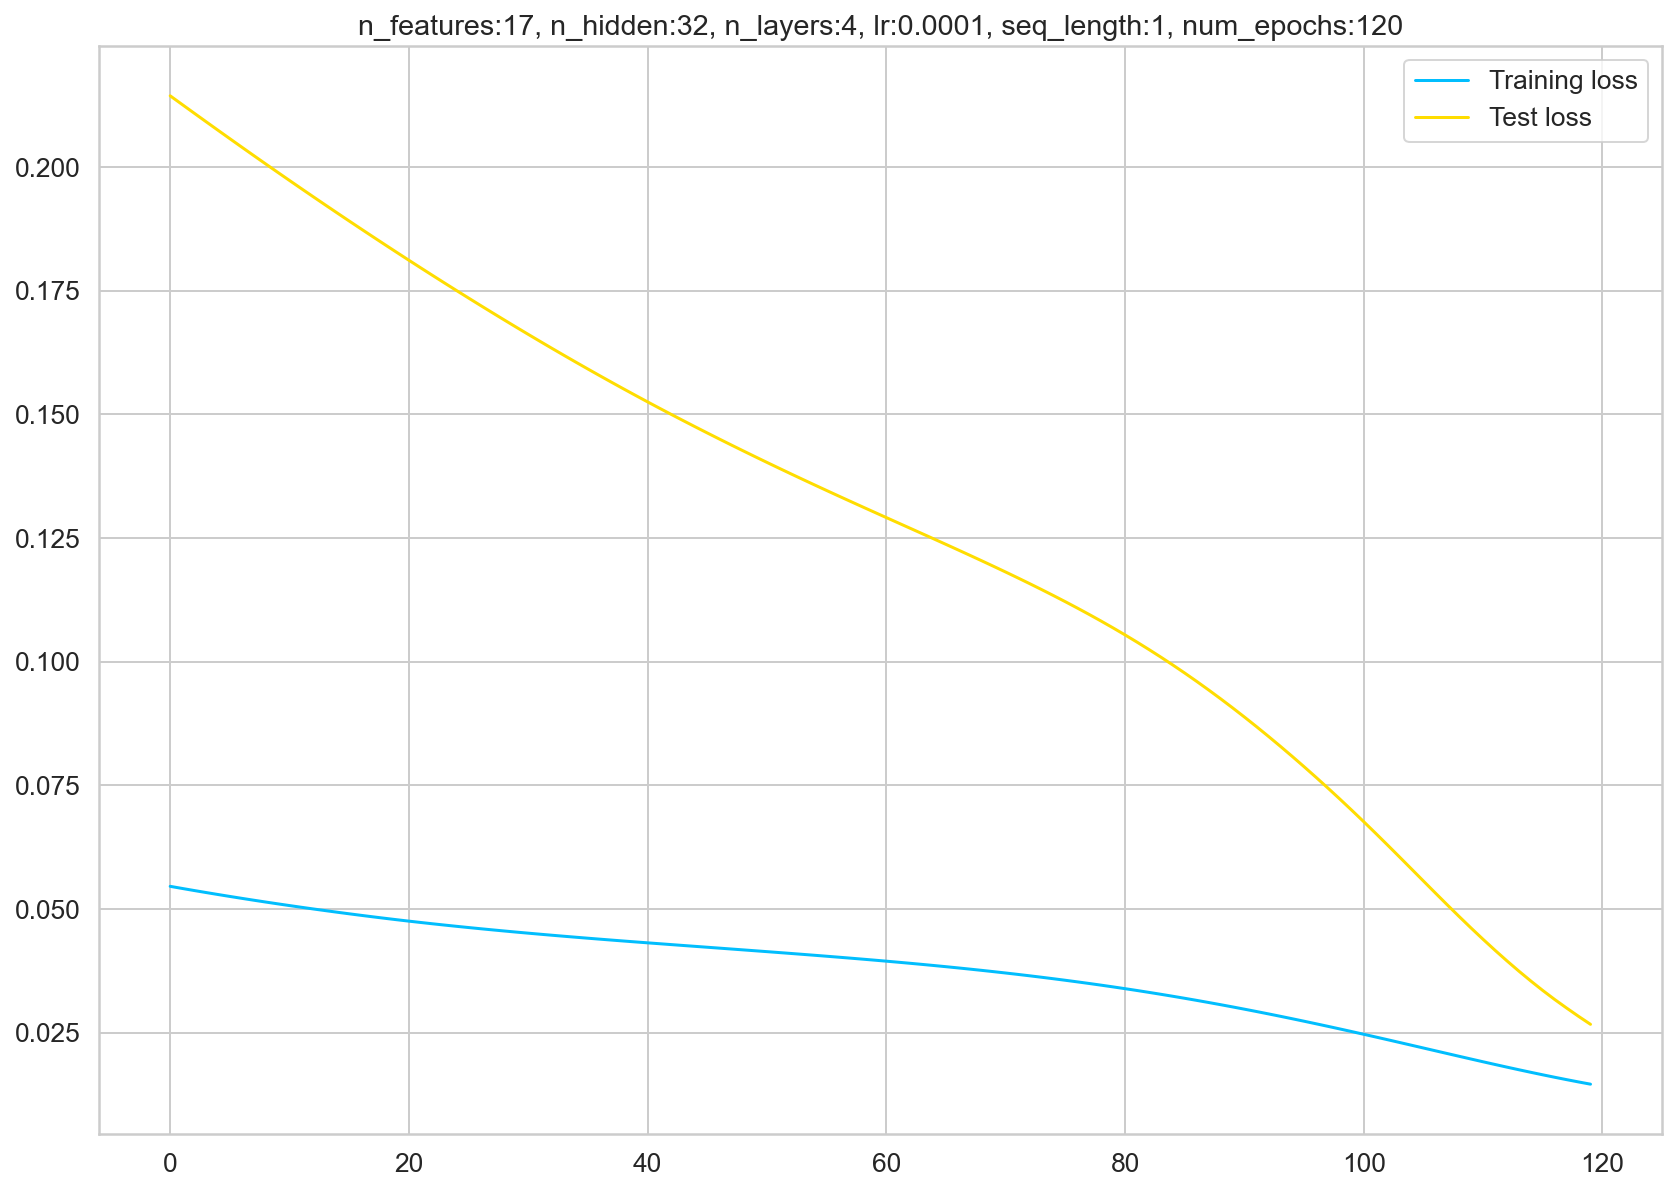

In [308]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

In [309]:
# 모델 저장
PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
torch.save(model, PATH)
# 모델 불러오기
model = torch.load(PATH)
#model.eval()

# Predicting daily cases

In [310]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [311]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [312]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
pred_values_ceiled

[12, 12, 12, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 12, 12, 12]

In [313]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [314]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [315]:
# validation score
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [316]:
score

58.21874605777722

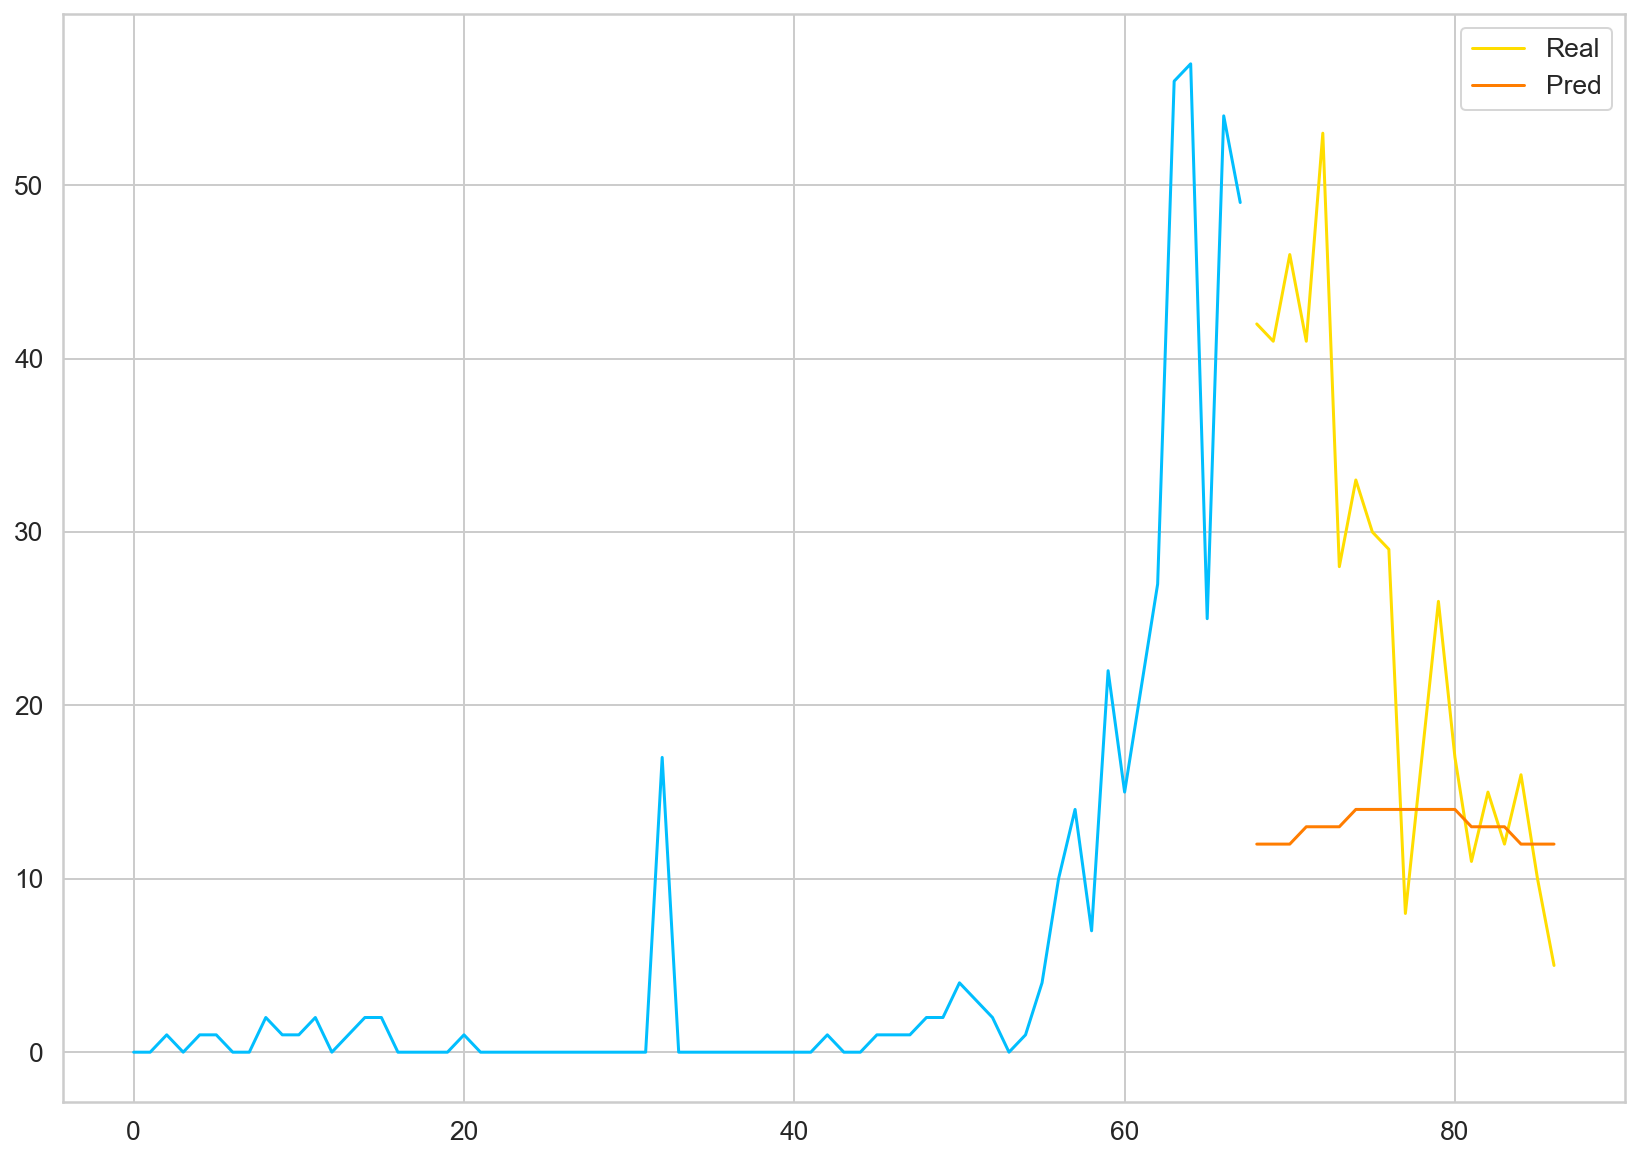

In [317]:
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
plt.legend()

# Use all data for training

In [318]:
# X변수들과 y변수 구분
X_all = df.iloc[:,:-1]
y_all = df.iloc[:,-1]

In [319]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [320]:
y_all

array([0.      , 0.      , 0.015625, 0.      , 0.015625, 0.015625,
       0.      , 0.      , 0.03125 , 0.015625, 0.015625, 0.03125 ,
       0.      , 0.015625, 0.03125 , 0.03125 , 0.      , 0.      ,
       0.      , 0.      , 0.015625, 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.265625, 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.015625, 0.      , 0.      , 0.015625, 0.015625, 0.015625,
       0.03125 , 0.03125 , 0.0625  , 0.046875, 0.03125 , 0.      ,
       0.015625, 0.0625  , 0.15625 , 0.21875 , 0.109375, 0.34375 ,
       0.234375, 0.328125, 0.421875, 0.875   , 0.890625, 0.390625,
       0.84375 , 0.765625, 1.      , 0.65625 , 0.65625 , 0.640625,
       0.71875 , 0.640625, 0.828125, 0.4375  , 0.515625, 0.46875 ,
       0.453125, 0.125   , 0.265625, 0.40625 , 0.265625, 0.171875,
       0.234375, 0.1875  , 0.25    , 0.15625 , 0.078125, 0.125

In [321]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (91, 17)
y_all :  (91,)


In [322]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    
    for i in range(len(array)-seq_length-1):
        tmp = array[i:(i+seq_length)]
        res.append(tmp)
        
    return res

In [323]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [324]:
model = CoronaVirusPredictor(
  n_features=n_features,
  n_hidden=n_hidden,
  seq_len=seq_length,
  n_layers=n_layers
)
model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.045414090156555176
Epoch 10 train loss: 0.04443126544356346
Epoch 20 train loss: 0.04353753477334976
Epoch 30 train loss: 0.04258589819073677
Epoch 40 train loss: 0.041430048644542694
Epoch 50 train loss: 0.039913445711135864
Epoch 60 train loss: 0.03784317150712013
Epoch 70 train loss: 0.034974414855241776
Epoch 80 train loss: 0.03127527981996536
Epoch 90 train loss: 0.027028175070881844
Epoch 100 train loss: 0.022599557414650917
Epoch 110 train loss: 0.018353303894400597


# Predicting future cases

In [325]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [326]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [327]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
predicted_cases=pred_values_ceiled
predicted_cases

[29, 28, 27, 24, 22, 19, 16, 14, 11, 10, 8, 7, 6, 5]

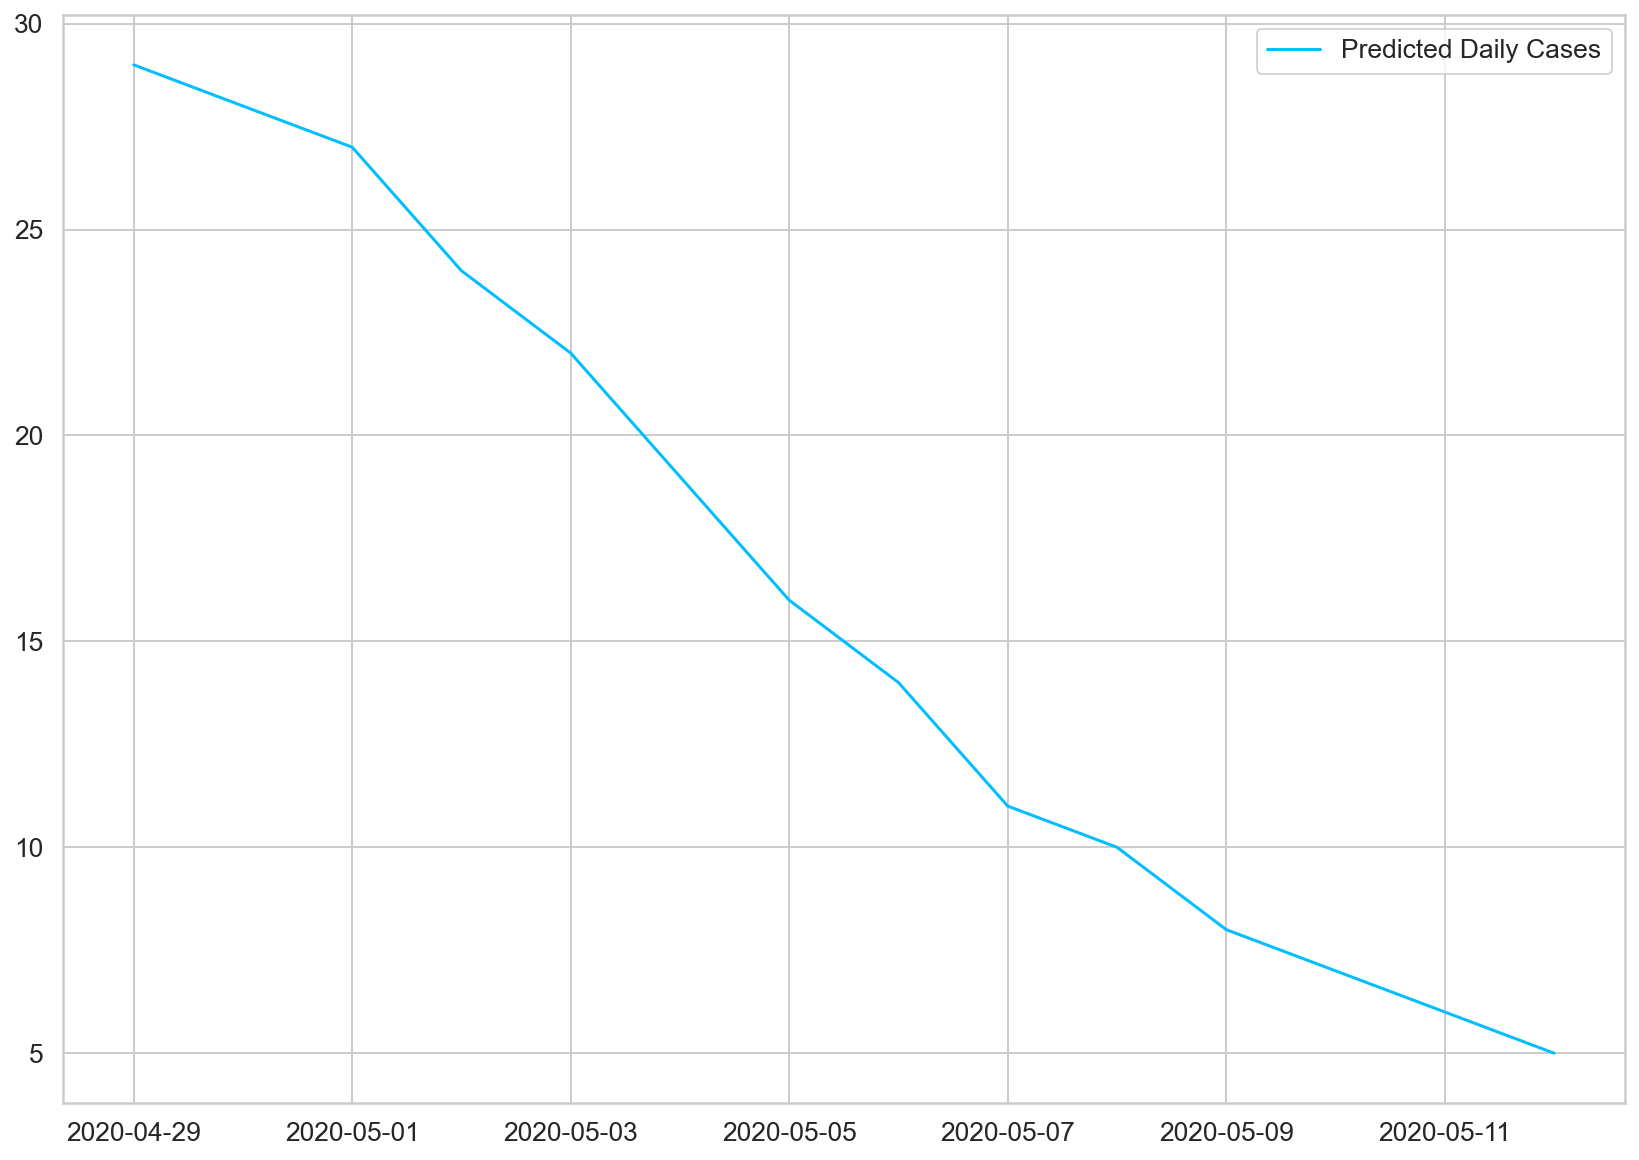

In [328]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [329]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [330]:
df['target']

Date
2020-01-29     0.0
2020-01-30     2.0
2020-01-31     1.0
2020-02-01     1.0
2020-02-02     2.0
              ... 
2020-04-24     2.0
2020-04-25     4.0
2020-04-26    10.0
2020-04-27     7.0
2020-04-28    12.0
Name: target, Length: 91, dtype: float64

In [331]:
preds_

,0
2020-04-29,29
2020-04-30,28
2020-05-01,27
2020-05-02,24
2020-05-03,22
2020-05-04,19
2020-05-05,16
2020-05-06,14
2020-05-07,11
2020-05-08,10


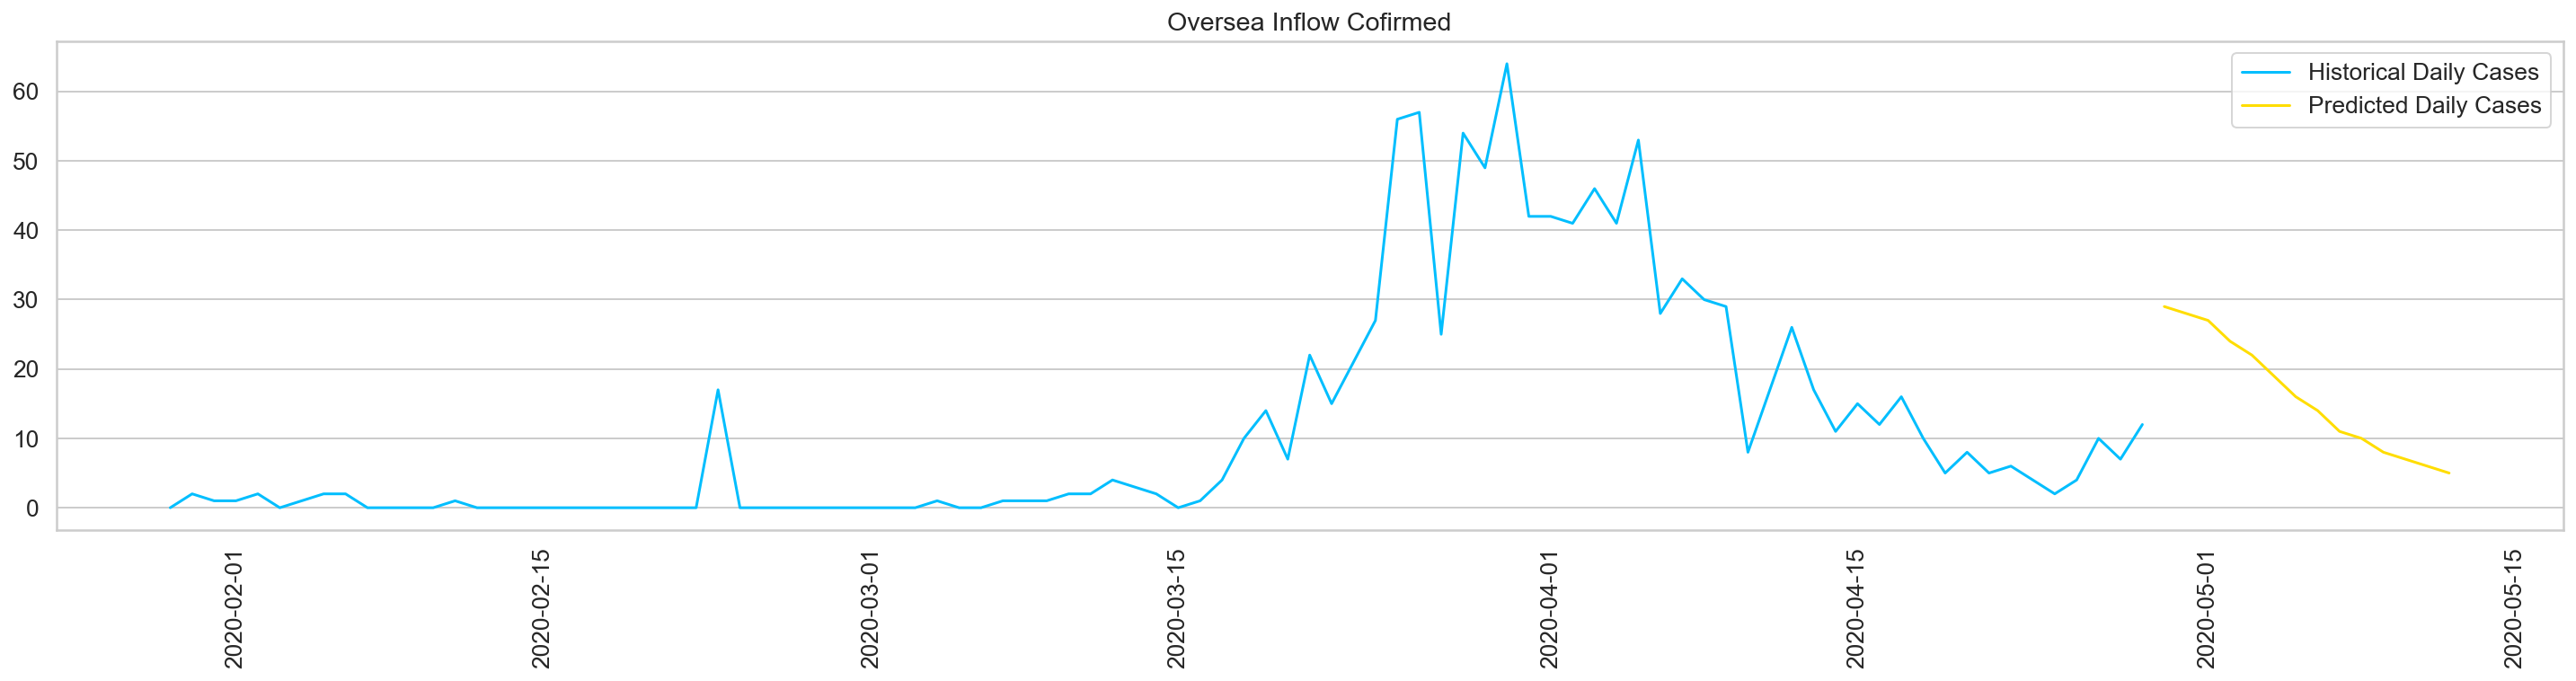

In [332]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();